## 1. Necessary Imports

In [1]:
import numpy as np
import pandas as pd
from skimpy import skim
import seaborn as sns
import plotly.express as px 
import spacy
import string
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import contractions
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import pickle
from textblob import TextBlob
import pyLDAvis.sklearn
from collections import Counter
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator

## 2. Reading the Data

In [2]:
data=pd.read_csv(r'C:\Users\princ\Downloads\Data Sets-20220921\Review.csv')

In [3]:
data.head()

sentiment_polarity  sentiment_polarity_confidence negative_reason  \
0            neutral                         1.0000             NaN   
1           positive                         0.3486             NaN   
2            neutral                         0.6837             NaN   
3           negative                         1.0000      Bad Flight   
4           negative                         1.0000      Can't Tell   

   negativereason_confidence    airline_name airline_sentiment_gold  \
0                        NaN  Virgin America                    NaN   
1                     0.0000  Virgin America                    NaN   
2                        NaN  Virgin America                    NaN   
3                     0.7033  Virgin America                    NaN   
4                     1.0000  Virgin America                    NaN   

         name negativereason_gold  retweet_count  \
0     cairdin                 NaN              0   
1    jnardino                 NaN              0   
2  yvonnalynn                 NaN              0   
3    jnardino                 NaN              0   
4    jnardino                 NaN              0   

                                              Review tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

    tweet_created tweet_location               user_timezone  
0  24/02/15 11:35            NaN  Eastern Time (US & Canada)  
1  24/02/15 11:15            NaN  Pacific Time (US & Canada)  
2  24/02/15 11:15      Lets Play  Central Time (US & Canada)  
3  24/02/15 11:15            NaN  Pacific Time (US & Canada)  
4  24/02/15 11:14            NaN  Pacific Time (US & Canada)

In [4]:
data.tail()

sentiment_polarity  sentiment_polarity_confidence  \
14635           positive                         0.3487   
14636           negative                         1.0000   
14637            neutral                         1.0000   
14638           negative                         1.0000   
14639            neutral                         0.6771   

              negative_reason  negativereason_confidence airline_name  \
14635                     NaN                     0.0000     American   
14636  Customer Service Issue                     1.0000     American   
14637                     NaN                        NaN     American   
14638  Customer Service Issue                     0.6659     American   
14639                     NaN                     0.0000     American   

      airline_sentiment_gold             name negativereason_gold  \
14635                    NaN  KristenReenders                 NaN   
14636                    NaN         itsropes                 NaN   
14637                    NaN         sanyabun                 NaN   
14638                    NaN       SraJackson                 NaN   
14639                    NaN        daviddtwu                 NaN   

       retweet_count                                             Review  \
14635              0  @AmericanAir thank you we got on a different f...   
14636              0  @AmericanAir leaving over 20 minutes Late Flig...   
14637              0  @AmericanAir Please bring American Airlines to...   
14638              0  @AmericanAir you have my money, you change my ...   
14639              0  @AmericanAir we have 8 ppl so we need 2 know h...   

      tweet_coord   tweet_created tweet_location               user_timezone  
14635         NaN  22/02/15 12:01            NaN                         NaN  
14636         NaN  22/02/15 11:59          Texas                         NaN  
14637         NaN  22/02/15 11:59  Nigeria,lagos                         NaN  
14638         NaN  22/02/15 11:59     New Jersey  Eastern Time (US & Canada)  
14639         NaN  22/02/15 11:58     dallas, TX                         NaN

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   sentiment_polarity             14640 non-null  object 
 1   sentiment_polarity_confidence  14640 non-null  float64
 2   negative_reason                9178 non-null   object 
 3   negativereason_confidence      10522 non-null  float64
 4   airline_name                   14640 non-null  object 
 5   airline_sentiment_gold         40 non-null     object 
 6   name                           14640 non-null  object 
 7   negativereason_gold            32 non-null     object 
 8   retweet_count                  14640 non-null  int64  
 9   Review                         14640 non-null  object 
 10  tweet_coord                    1019 non-null   object 
 11  tweet_created                  14640 non-null  object 
 12  tweet_location                 9907 non-null  

In [6]:
data.shape

(14640, 14)

In [7]:
data.describe(include='all').T

count unique                         top  \
sentiment_polarity               14640      3                    negative   
sentiment_polarity_confidence  14640.0    NaN                         NaN   
negative_reason                   9178     10      Customer Service Issue   
negativereason_confidence      10522.0    NaN                         NaN   
airline_name                     14640      6                      United   
airline_sentiment_gold              40      3                    negative   
name                             14640   7701                 JetBlueNews   
negativereason_gold                 32     13      Customer Service Issue   
retweet_count                  14640.0    NaN                         NaN   
Review                           14640  14427              @united thanks   
tweet_coord                       1019    832                  [0.0, 0.0]   
tweet_created                    14640   6804              22/02/15 14:22   
tweet_location                    9907   3081                  Boston, MA   
user_timezone                     9820     85  Eastern Time (US & Canada)   

                               freq      mean       std    min     25%  \
sentiment_polarity             9178       NaN       NaN    NaN     NaN   
sentiment_polarity_confidence   NaN  0.900169   0.16283  0.335  0.6923   
negative_reason                2910       NaN       NaN    NaN     NaN   
negativereason_confidence       NaN  0.638298   0.33044    0.0  0.3606   
airline_name                   3822       NaN       NaN    NaN     NaN   
airline_sentiment_gold           32       NaN       NaN    NaN     NaN   
name                             63       NaN       NaN    NaN     NaN   
negativereason_gold              12       NaN       NaN    NaN     NaN   
retweet_count                   NaN   0.08265  0.745778    0.0     0.0   
Review                            6       NaN       NaN    NaN     NaN   
tweet_coord                     164       NaN       NaN    NaN     NaN   
tweet_created                    11       NaN       NaN    NaN     NaN   
tweet_location                  157       NaN       NaN    NaN     NaN   
user_timezone                  3744       NaN       NaN    NaN     NaN   

                                  50%  75%   max  
sentiment_polarity                NaN  NaN   NaN  
sentiment_polarity_confidence     1.0  1.0   1.0  
negative_reason                   NaN  NaN   NaN  
negativereason_confidence      0.6706  1.0   1.0  
airline_name                      NaN  NaN   NaN  
airline_sentiment_gold            NaN  NaN   NaN  
name                              NaN  NaN   NaN  
negativereason_gold               NaN  NaN   NaN  
retweet_count                     0.0  0.0  44.0  
Review                            NaN  NaN   NaN  
tweet_coord                       NaN  NaN   NaN  
tweet_created                     NaN  NaN   NaN  
tweet_location                    NaN  NaN   NaN  
user_timezone                     NaN  NaN   NaN

In [8]:
data.isna().mean()*100

sentiment_polarity                0.000000
sentiment_polarity_confidence     0.000000
negative_reason                  37.308743
negativereason_confidence        28.128415
airline_name                      0.000000
airline_sentiment_gold           99.726776
name                              0.000000
negativereason_gold              99.781421
retweet_count                     0.000000
Review                            0.000000
tweet_coord                      93.039617
tweet_created                     0.000000
tweet_location                   32.329235
user_timezone                    32.923497
dtype: float64

#### Here we observe that airline_sentiment_gold , negativereason_gold and tweet_coord has most of the null values(greater than 90%) , so we can drop those columns from our dataset alongwith the variables that are not useful to us .

In [9]:
df=data.drop(['name','tweet_coord','tweet_created','tweet_location','user_timezone','airline_sentiment_gold','negativereason_gold'],axis=1)

#### Now we need to treat the missing values in our dataset 

In [10]:
df.negative_reason.unique()

array([nan, 'Bad Flight', "Can't Tell", 'Late Flight',
       'Customer Service Issue', 'Flight Booking Problems',
       'Lost Luggage', 'Flight Attendant Complaints', 'Cancelled Flight',
       'Damaged Luggage', 'longlines'], dtype=object)

In [11]:
df.negative_reason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negative_reason, dtype: int64

In [12]:
df['negative_reason']=df['negative_reason'].fillna('Unknown') # filling the missing values with unknown

In [13]:
df['negativereason_confidence']=df['negativereason_confidence'].replace(np.nan,df['negativereason_confidence'].mean()) #filling the missing values with mean value

In [14]:
df.isna().mean()*100

sentiment_polarity               0.0
sentiment_polarity_confidence    0.0
negative_reason                  0.0
negativereason_confidence        0.0
airline_name                     0.0
retweet_count                    0.0
Review                           0.0
dtype: float64

#### Missing values have been treated now.

In [15]:
df.dtypes

sentiment_polarity                object
sentiment_polarity_confidence    float64
negative_reason                   object
negativereason_confidence        float64
airline_name                      object
retweet_count                      int64
Review                            object
dtype: object

In [16]:
df.head()

sentiment_polarity  sentiment_polarity_confidence negative_reason  \
0            neutral                         1.0000         Unknown   
1           positive                         0.3486         Unknown   
2            neutral                         0.6837         Unknown   
3           negative                         1.0000      Bad Flight   
4           negative                         1.0000      Can't Tell   

   negativereason_confidence    airline_name  retweet_count  \
0                   0.638298  Virgin America              0   
1                   0.000000  Virgin America              0   
2                   0.638298  Virgin America              0   
3                   0.703300  Virgin America              0   
4                   1.000000  Virgin America              0   

                                              Review  
0                @VirginAmerica What @dhepburn said.  
1  @VirginAmerica plus you've added commercials t...  
2  @VirginAmerica I didn't today... Must mean I n...  
3  @VirginAmerica it's really aggressive to blast...  
4  @VirginAmerica and it's a really big bad thing...

#### Let's look at some of the variables 

In [17]:
df.sentiment_polarity.unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [18]:
fig = px.histogram(df, x="sentiment_polarity", category_orders=dict(day=["neutral","positive","negative"]), color='airline_name',title="Histogram Plot for different category of reviews")
fig.show()

C:\Users\princ\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\princ\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [19]:
df.negative_reason.unique()

array(['Unknown', 'Bad Flight', "Can't Tell", 'Late Flight',
       'Customer Service Issue', 'Flight Booking Problems',
       'Lost Luggage', 'Flight Attendant Complaints', 'Cancelled Flight',
       'Damaged Luggage', 'longlines'], dtype=object)

In [20]:
fig = px.histogram(df, x="negative_reason", category_orders=dict(day=["neutral","positive","negative"]), color='airline_name',title="Histogram Plot for different categories of reviews")
fig.show()

C:\Users\princ\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\princ\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [21]:
df.head()

sentiment_polarity  sentiment_polarity_confidence negative_reason  \
0            neutral                         1.0000         Unknown   
1           positive                         0.3486         Unknown   
2            neutral                         0.6837         Unknown   
3           negative                         1.0000      Bad Flight   
4           negative                         1.0000      Can't Tell   

   negativereason_confidence    airline_name  retweet_count  \
0                   0.638298  Virgin America              0   
1                   0.000000  Virgin America              0   
2                   0.638298  Virgin America              0   
3                   0.703300  Virgin America              0   
4                   1.000000  Virgin America              0   

                                              Review  
0                @VirginAmerica What @dhepburn said.  
1  @VirginAmerica plus you've added commercials t...  
2  @VirginAmerica I didn't today... Must mean I n...  
3  @VirginAmerica it's really aggressive to blast...  
4  @VirginAmerica and it's a really big bad thing...

In [22]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 14640  │ │ string      │ 4     │                                                          │
│ │ Number of columns │ 7      │ │ float64     │ 2     │                                                          │
│ └───────────────────┴────────┘ │ int32       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name                 ┃ NA   ┃ NA %   ┃ mean    ┃ sd     ┃ p0     ┃ p25    ┃ p75   ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ sentiment_polarity_c        │    0 │      0 │     0.9 │   0.16 │   0.34 │   0.69 │     1 │     1 │   ▁▂ █  │  │
│ │ negativereason_confi        │    0 │      0 │    0.64 │   0.28 │      0 │   0.64 │   0.7 │     1 │ ▂ ▂█▃▅  │  │
│ │ retweet_count               │    0 │      0 │   0.083 │   0.75 │      0 │      0 │     0 │    44 │    █    │  │
│ └─────────────────────────────┴──────┴────────┴─────────┴────────┴────────┴────────┴───────┴───────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                        ┃ NA     ┃ NA %      ┃ words per row             ┃ total words          ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ sentiment_polarity                 │      0 │         0 │                         1 │                15000 │  │
│ │ negative_reason                    │      0 │         0 │                         1 │                15000 │  │
│ │ airline_name                       │      0 │         0 │                         1 │                15000 │  │
│ │ Review                             │      0 │         0 │                         1 │                15000 │  │
│ └────────────────────────────────────┴────────┴───────────┴───────────────────────────┴──────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

#### Cleaning the text data 

In [23]:
df_text=df.iloc[:,6:7]
df_text

Review
0                    @VirginAmerica What @dhepburn said.
1      @VirginAmerica plus you've added commercials t...
2      @VirginAmerica I didn't today... Must mean I n...
3      @VirginAmerica it's really aggressive to blast...
4      @VirginAmerica and it's a really big bad thing...
...                                                  ...
14635  @AmericanAir thank you we got on a different f...
14636  @AmericanAir leaving over 20 minutes Late Flig...
14637  @AmericanAir Please bring American Airlines to...
14638  @AmericanAir you have my money, you change my ...
14639  @AmericanAir we have 8 ppl so we need 2 know h...

[14640 rows x 1 columns]

In [24]:
df_text.head()

Review
0                @VirginAmerica What @dhepburn said.
1  @VirginAmerica plus you've added commercials t...
2  @VirginAmerica I didn't today... Must mean I n...
3  @VirginAmerica it's really aggressive to blast...
4  @VirginAmerica and it's a really big bad thing...

In [25]:
import en_core_web_sm

In [26]:
text=df_text['Review'][399]
text

'@VirginAmerica I am in seat 4C and I cannot even open my laptop; and I paid extra for this seat!!'

In [27]:
nlp=en_core_web_sm.load()
doc=nlp(text)

C:\Users\princ\anaconda3\lib\site-packages\spacy\language.py:1895: UserWarning:

[W123] Argument disable with value [] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.



- #### Lowercasing the text

In [28]:
text=text.lower()
text

'@virginamerica i am in seat 4c and i cannot even open my laptop; and i paid extra for this seat!!'

- #### Removing Unicode Characters 

In [29]:
text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
print(text)

virginamerica i am in seat 4c and i cannot even open my laptop and i paid extra for this seat


- #### Removing Punctuations

In [30]:
text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
print(text)

virginamerica i am in seat 4c and i cannot even open my laptop and i paid extra for this seat


- #### Removing Numbers

In [31]:
text = ''.join([i for i in text if not i.isdigit()])
text

'virginamerica i am in seat c and i cannot even open my laptop and i paid extra for this seat'

- #### Removing Extra Space

In [32]:
text = " ".join(text.split())
text

'virginamerica i am in seat c and i cannot even open my laptop and i paid extra for this seat'

- #### Replacing the Repetitions of Punctuations

In [33]:
text = re.sub(r'(!)1+', '', text)
text

'virginamerica i am in seat c and i cannot even open my laptop and i paid extra for this seat'

In [34]:
text = re.sub(r'(!|.)1+', '', text) 
text

'virginamerica i am in seat c and i cannot even open my laptop and i paid extra for this seat'

- #### Removing Emojis

In [35]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"U0001F600-U0001F64F"  # emoticons
                           u"U0001F300-U0001F5FF"  # symbols & pictographs
                           u"U0001F680-U0001F6FF"  # transport & map symbols
                           u"U0001F1E0-U0001F1FF"  # flags (iOS)
                           u"U00002702-U000027B0"
                           u"U000024C2-U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
remove_emoji(text)

'virginamerica i am in seat c and i cannot even open my laptop and i paid extra for this seat'

- #### Removing Contractions

In [36]:
contractions.fix(text)

'virginamerica i am in seat c and i cannot even open my laptop and i paid extra for this seat'

- #### Removing Stopwords

In [37]:
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
text = " ".join([word for word in text.split() if word not in (stop)])

print(text)

virginamerica seat c cannot even open laptop paid extra seat


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\princ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- #### Stemming

In [38]:
from nltk.tokenize import word_tokenize
words=word_tokenize(text)
words

['virginamerica',
 'seat',
 'c',
 'can',
 'not',
 'even',
 'open',
 'laptop',
 'paid',
 'extra',
 'seat']

- #### Performing Lemmatization

In [39]:
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
for word in words:
    print(word + " = " + lemmatizer.lemmatize(word))

virginamerica = virginamerica
seat = seat
c = c
can = can
not = not
even = even
open = open
laptop = laptop
paid = paid
extra = extra
seat = seat


- #### Parts of Speech (POS) Tagging

In [40]:
tokens = nltk.word_tokenize(text)
print(tokens)

['virginamerica', 'seat', 'c', 'can', 'not', 'even', 'open', 'laptop', 'paid', 'extra', 'seat']


In [41]:
pos = nltk.pos_tag(tokens)
print(pos)

[('virginamerica', 'JJ'), ('seat', 'NN'), ('c', 'NNS'), ('can', 'MD'), ('not', 'RB'), ('even', 'RB'), ('open', 'JJ'), ('laptop', 'NN'), ('paid', 'VBN'), ('extra', 'JJ'), ('seat', 'NN')]


In [42]:
features=[]
for token in doc:
    features.append({'token':token.text,'pos':token.pos_})

In [43]:
fdf=pd.DataFrame(features)
fdf.head(len(fdf))

token    pos
0   @VirginAmerica   NOUN
1                I   PRON
2               am    AUX
3               in    ADP
4             seat   NOUN
5               4C   NOUN
6              and  CCONJ
7                I   PRON
8              can    AUX
9              not   PART
10            even    ADV
11            open   VERB
12              my   PRON
13          laptop   NOUN
14               ;  PUNCT
15             and  CCONJ
16               I   PRON
17            paid   VERB
18           extra    ADJ
19             for    ADP
20            this    DET
21            seat   NOUN
22               !  PUNCT
23               !  PUNCT

### Exploratory Data Analysis

In [44]:
df

sentiment_polarity  sentiment_polarity_confidence  \
0                neutral                         1.0000   
1               positive                         0.3486   
2                neutral                         0.6837   
3               negative                         1.0000   
4               negative                         1.0000   
...                  ...                            ...   
14635           positive                         0.3487   
14636           negative                         1.0000   
14637            neutral                         1.0000   
14638           negative                         1.0000   
14639            neutral                         0.6771   

              negative_reason  negativereason_confidence    airline_name  \
0                     Unknown                   0.638298  Virgin America   
1                     Unknown                   0.000000  Virgin America   
2                     Unknown                   0.638298  Virgin America   
3                  Bad Flight                   0.703300  Virgin America   
4                  Can't Tell                   1.000000  Virgin America   
...                       ...                        ...             ...   
14635                 Unknown                   0.000000        American   
14636  Customer Service Issue                   1.000000        American   
14637                 Unknown                   0.638298        American   
14638  Customer Service Issue                   0.665900        American   
14639                 Unknown                   0.000000        American   

       retweet_count                                             Review  
0                  0                @VirginAmerica What @dhepburn said.  
1                  0  @VirginAmerica plus you've added commercials t...  
2                  0  @VirginAmerica I didn't today... Must mean I n...  
3                  0  @VirginAmerica it's really aggressive to blast...  
4                  0  @VirginAmerica and it's a really big bad thing...  
...              ...                                                ...  
14635              0  @AmericanAir thank you we got on a different f...  
14636              0  @AmericanAir leaving over 20 minutes Late Flig...  
14637              0  @AmericanAir Please bring American Airlines to...  
14638              0  @AmericanAir you have my money, you change my ...  
14639              0  @AmericanAir we have 8 ppl so we need 2 know h...  

[14640 rows x 7 columns]

- #### Taking a look at some of the reviews 

In [45]:
for index,text in enumerate(df['Review'][60:90]):
    print('Review %d:\n'%(index+1),text)

Review 1:
 @VirginAmerica @ladygaga @carrieunderwood Julie Andrews first but Lady Gaga wow'd me last night. Carrie? Meh.
Review 2:
 @VirginAmerica I called a 3-4 weeks ago about adding 3 flights from 2014 to my Elevate...they still haven't shown up...help!
Review 3:
 @VirginAmerica @ladygaga @carrieunderwood all are great , but I have to go with #CarrieUnderwood 😍👌
Review 4:
 @VirginAmerica @LadyGaga @CarrieUnderwood Sorry, Mary Martin had it first!
Review 5:
 @VirginAmerica @ladygaga @carrieunderwood  love all three but you really can't beat the classics!
Review 6:
 @VirginAmerica Flight 0736 DAL to DCA 2/24 2:10pm. Tried to check in could not. Status please.
Review 7:
 @VirginAmerica heyyyy guyyyys.. been trying to get through for an hour. can someone call me please? :/
Review 8:
 @VirginAmerica Hi, Virgin! I'm on hold for 40-50 minutes -- are there any earlier flights from LA to NYC tonight; earlier than 11:50pm?
Review 9:
 @VirginAmerica Congrats on winning the @Travelzoo award for

In [46]:
# Here we see that the reviews contains @Airline_name , emojis , url ,
#punctuations like ('!,?,&'),contracted words like can't ,etc, digits , seat numbers , location , hashtags

- #### Lowercasing the reviews

In [47]:
#Converted Reviews to lowercase
df['Review']=df['Review'].apply(lambda x: x.lower())

In [48]:
for index,text in enumerate(df['Review'][35:36]):
    print('Review %d:\n'%(index+1),text)

Review 1:
 nice rt @virginamerica: vibe with the moodlight from takeoff to touchdown. #moodlitmonday #sciencebehindtheexperience http://t.co/y7o0unxtqp


- #### Expanding Contractions

In [49]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we’ll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have","united's":"united is ",
                    
                    "ain’t": "are not","’s":" is","aren’t": "are not",
                     "can’t": "cannot","can’t’ve": "cannot have",
                     "’cause": "because","could’ve": "could have","couldn’t": "could not",
                     "couldn’t’ve": "could not have", "didn’t": "did not","doesn’t": "does not",
                     "don’t": "do not","hadn’t": "had not","hadn’t’ve": "had not have",
                     "hasn’t": "has not","have’nt": "have not","he’d": "he would",
                     "he’d’ve": "he would have","he’ll": "he will", "he’ll’ve": "he will have",
                     "how’d": "how did","how’d’y": "how do you","how’ll": "how will",
                     "I’d": "I would", "I’d’ve": "I would have","I’ll": "I will",
                     "I’ll’ve": "I will have","I’m": "I am","I’ve": "I have", "isn’t": "is not",
                     "it’d": "it would","it’d’ve": "it would have","it’ll": "it will",
                     "it’ll’ve": "it will have", "let’s": "let us","ma’am": "madam",
                     "mayn’t": "may not","might’ve": "might have","might’nt": "might not", 
                     "mightn’t’ve": "might not have","must’ve": "must have","mustn’t": "must not",
                     "mustn’t’ve": "must not have", "needn’t": "need not",
                     "needn’t’ve": "need not have","o’clock": "of the clock","oughtn’t": "ought not",
                     "oughtn’t’ve": "ought not have","shan’t": "shall not","sha’n’t": "shall not",
                     "shan’t’ve": "shall not have","she’d": "she would","she’d’ve": "she would have",
                     "she’ll": "she will", "she'll’ve": "she will have","should’ve": "should have",
                     "shouldn’t": "should not", "shouldn’t’ve": "should not have","so’ve": "so have",
                     "that’d": "that would","that’d’ve": "that would have", "there’d": "there would",
                     "there’d’ve": "there would have", "they’d": "they would",
                     "they’d’ve": "they would have","they’ll": "they will",
                     "they’ll’ve": "they will have", "they’re": "they are","they’ve": "they have",
                     "to’ve": "to have","wasn’t": "was not","we’d": "we would",
                     "we’d've": "we would have","we’ll": "we will","we’ll": "we will","we’ll've": "we will have",
                     "we’re": "we are","we’ve": "we have", "weren’t": "were not","what’ll": "what will",
                     "what’ll've": "what will have","what’re": "what are", "what’ve": "what have",
                     "when’ve": "when have","where’d": "where did", "where’ve": "where have",
                     "who’ll": "who will","who’ll've": "who will have","who’ve": "who have",
                     "why’ve": "why have","will’ve": "will have","won’t": "will not",
                     "won’t've": "will not have", "would’ve": "would have","wouldn’t": "would not",
                     "wouldn’t’ve": "would not have","y’all": "you all", "y’all’d": "you all would",
                     "y’all’d’ve": "you all would have","y’all’re": "you all are",
                     "y’all’ve": "you all have", "you’d": "you would","you’d’ve": "you would have",
                     "you’ll": "you will","you’ll’ve": "you will have", "you’re": "you are",
                     "you’ve": "you have","united’s":"united is ","wow'd":"wow"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df['Review']=df['Review'].apply(lambda x:expand_contractions(x))

In [50]:
#checking if words have been expanded
for index,text in enumerate(df['Review'][80:87]):
    print('Review %d:\n'%(index+1),text)

Review 1:
 @virginamerica why cannot you supp the biz traveler like @southwestair  and have customer service like @jetblue #neverflyvirginforbusiness
Review 2:
 @virginamerica i've applied more then once to be a member of the #inflight crew team...im 100% interested. #flightattendant #dreampath -g
Review 3:
 @virginamerica you are the best!! whenever i (begrudgingly) use any other airline i'm delayed and late flight :(
Review 4:
 @virginamerica i have no interesting flying with you after this. i will cancelled flight my next four flights i planned.#neverflyvirginforbusiness
Review 5:
 @virginamerica it was a disappointing experience which will be shared with every business traveler i meet. #neverflyvirgin
Review 6:
 @virginamerica i’m having trouble adding this flight my wife booked to my elevate account. help? http://t.co/px8hqoks3r
Review 7:
 @virginamerica cannot bring up my reservation online using flight booking problems code


- #### Removing digits and words containing digits

In [51]:
df['Review']=df['Review'].apply(lambda x: re.sub('\w*\d\w*','', x))

<>:1: DeprecationWarning:

invalid escape sequence \w

<>:1: DeprecationWarning:

invalid escape sequence \w

C:\Users\princ\AppData\Local\Temp\ipykernel_17864\1810073367.py:1: DeprecationWarning:

invalid escape sequence \w



In [52]:
for index,text in enumerate(df['Review'][60:62]):
    print('Review %d:\n'%(index+1),text)

Review 1:
 @virginamerica @ladygaga @carrieunderwood julie andrews first but lady gaga wow me last night. carrie? meh.
Review 2:
 @virginamerica i called a - weeks ago about adding  flights from  to my elevate...they still have not shown up...help!


- #### Removing Punctuations

In [53]:
df['Review']=df['Review'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [54]:
for index,text in enumerate(df['Review'][60:61]):
    print('Review %d:\n'%(index+1),text)

Review 1:
 virginamerica ladygaga carrieunderwood julie andrews first but lady gaga wow me last night carrie meh


- #### Removing Extra Spaces

In [55]:
df['Review']=df['Review'].apply(lambda x: re.sub(' +',' ',x))

In [56]:
for index,text in enumerate(df['Review'][66:67]):
    print('Review %d:\n'%(index+1),text)

Review 1:
 virginamerica heyyyy guyyyys been trying to get through for an hour can someone call me please 


- #### Removing Stopwords

In [57]:
stop_words=["a","about","above","after","again","against","ain","all","am","an","and","any","are","aren",
            "aren't","as","at","be","because","been","before","being","below","between","both","but","by",
            "can","couldn","couldn't","d","did","didn","didn't","do","does","doesn","doesn't","doing","don",
            "don't","down","during","each","few","for","from","further","had","hadn","hadn't","has","hasn",
            "hasn't","have","haven","haven't","having","he","her","here","hers","herself","him","himself","his",
            "how","i","if","in","into","is","isn","isn't","it","it's","its","itself","just","ll","m","ma","me",
            "mightn","mightn't","more","most","mustn","mustn't","my","myself","needn","needn't","no","nor","not",
            "now","o","of","off","on","once","only","or","other","our","ours","ourselves","out","over","own",
            "re","s","same","shan","shan't","she","she's","should","should've","shouldn","shouldn't","so","some",
            "such","t","than","that","that'll","the","their","theirs","them","themselves","then","there","these",
            "they","this","those","through","to","too","under","until","up","ve","very","was","wasn","wasn't",
            "we","were","weren","weren't","what","when","where","which","while","who","whom","why","will","with",
            "won","won't","wouldn","wouldn't","y","you","you'd","you'll","you're","you've","your","yours",
            "yourself","yourselves","could","he'd","he'll","he's","here's","how's","i'd","i'll","i'm","i've",
            "let's","ought","she'd","she'll","that's","there's","they'd","they'll","they're","they've","we'd",
            "we'll","we're","we've","what's","when's","where's","who's","why's","would","able","abst",
            "accordance","according","accordingly","across","act","actually","added","adj","affected","affecting","affects","afterwards","ah",
            "almost","alone","along","already","also","although","always","among","amongst","announce","another","anybody","anyhow","anymore",
            "anyone","anything","anyway","anyways","anywhere","apparently","approximately","arent","arise","around","aside","ask","asking","auth",
            "available","away","awfully","b","back","became","become","becomes","becoming","beforehand","begin","beginning","beginnings","begins",
            "behind","believe","beside","besides","beyond","biol","brief","briefly","c","ca","came","cannot","can't","cause","causes","certain",
            "certainly","co","com","come","comes","contain","containing","contains","couldnt","date","different","done","downwards","due","e","ed",
            "edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough","especially","et","etc","even","ever","every",
            "everybody","everyone","everything","everywhere","ex","except","f","far","ff","fifth","first","five","fix","followed","following",
            "follows","former","formerly","forth","found","four","furthermore","g","gave","get","gets","getting","give","given","gives","giving",
            "go","goes","gone","got","gotten","h","happens","hardly","hed","hence","hereafter","hereby","herein","heres","hereupon","hes","hi",
            "hid","hither","home","howbeit","however","hundred","id","ie","im","immediate","immediately","importance","important","inc","indeed",
            "index","information","instead","invention","inward","itd","it'll","j","k","keep","keeps","kept","kg","km","know","known","knows","l",
            "largely","last","lately","later","latter","latterly","least","less","lest","let","lets","like","liked","likely","line","little","'ll",
            "look","looking","looks","ltd","made","mainly","make","makes","many","may","maybe","mean","means","meantime","meanwhile","merely","mg",
            "might","million","miss","ml","moreover","mostly","mr","mrs","much","mug","must","n","na","name","namely","nay","nd","near","nearly",
            "necessarily","necessary","need","needs","neither","never","nevertheless","new","next","nine","ninety","nobody","non","none",
            "nonetheless","noone","normally","nos","noted","nothing","nowhere","obtain","obtained","obviously","often","oh","ok","okay","old",
            "omitted","one","ones","onto","ord","others","otherwise","outside","overall","owing","p","page","pages","part","particular",
            "particularly","past","per","perhaps","placed","please","plus","poorly","possible","possibly","potentially","pp","predominantly",
            "present","previously","primarily","probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather",
            "rd","readily","really","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research",
            "respectively","resulted","resulting","results","right","run","said","saw","say","saying","says","sec","section","see","seeing",
            "seem","seemed","seeming","seems","seen","self","selves","sent","seven","several","shall","shed","shes","show","showed","shown","showns","shows","significant","significantly","similar","similarly","since","six","slightly","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","stop","strongly","sub","substantially","successfully","sufficiently","suggest","sup","sure","take","taken","taking","tell","tends","th","thank","thanks","thanx","thats","that've","thence","thereafter","thereby","thered","therefore","therein","there'll","thereof","therere","theres","thereto","thereupon","there've","theyd","theyre","think","thou","though","thoughh","thousand","throug","throughout","thru","thus","til","tip","together","took","toward","towards","tried","tries","truly","try","trying","ts","twice","two","u","un","unfortunately","unless","unlike","unlikely","unto","upon","ups","us","use","used","useful","usefully","usefulness","uses","using","usually","v","value","various","'ve","via","viz","vol","vols","vs","w","want","wants","wasnt","way","wed","welcome","went","werent","whatever","what'll","whats","whence","whenever","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","whim","whither","whod","whoever","whole","who'll","whomever","whos","whose","widely","willing","wish","within","without","wont","words","world","wouldnt","www","x","yes","yet","youd","youre","z","zero","a's","ain't","allow","allows","apart","appear","appreciate","appropriate","associated","best","better","c'mon","c's","cant","changes","clearly","concerning","consequently","consider","considering","corresponding","course","currently","definitely","described","despite","entirely","exactly","example","going","greetings","hello","help","hopefully","ignored","inasmuch","indicate","indicated","indicates","inner","insofar","it'd","keep","keeps","novel","presumably","reasonably","second","secondly","sensible","serious","seriously","sure","t's","third","thorough","thoroughly","three","well","wonder"]

In [58]:
df['Review']=df['Review'].apply(lambda x: re.sub('stop_words',' ',x))

In [59]:
for index,text in enumerate(df['Review'][60:70]):
    print('Review %d:\n'%(index+1),text)

Review 1:
 virginamerica ladygaga carrieunderwood julie andrews first but lady gaga wow me last night carrie meh
Review 2:
 virginamerica i called a weeks ago about adding flights from to my elevatethey still have not shown uphelp
Review 3:
 virginamerica ladygaga carrieunderwood all are great but i have to go with carrieunderwood 😍👌
Review 4:
 virginamerica ladygaga carrieunderwood sorry mary martin had it first
Review 5:
 virginamerica ladygaga carrieunderwood love all three but you really cannot beat the classics
Review 6:
 virginamerica flight dal to dca tried to check in could not status please
Review 7:
 virginamerica heyyyy guyyyys been trying to get through for an hour can someone call me please 
Review 8:
 virginamerica hi virgin im on hold for minutes are there any earlier flights from la to nyc tonight earlier than 
Review 9:
 virginamerica congrats on winning the travelzoo award for best deals from an airline us httptco
Review 10:
 virginamerica everything was fine until yo

- #### Removing Emojis

In [60]:
from cleantext import clean
clean(text, no_emoji=True)

'virginamerica everything was fine until you lost my bag'

In [61]:
emojis=["U+1F44D","U+1F603","U+2708","U+1F44E","U+1F612","U+1F60D","U+1F609","U+2665","U+1F60D","U+1F495","U+2934","U+1F602"]
df['Review']=df['Review'].apply(lambda x: re.sub('emojis','',x))

In [62]:
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
df['lemmatized']=df['Review'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))


C:\Users\princ\anaconda3\lib\site-packages\spacy\language.py:1895: UserWarning:

[W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.



In [63]:
for index,text in enumerate(df['Review']):
    print('Review %d:\n'%(index+1),text)

Review 1:
 virginamerica what dhepburn said
Review 2:
 virginamerica plus you have added commercials to the experience tacky
Review 3:
 virginamerica i did not today must mean i need to take another trip
Review 4:
 virginamerica it is really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse
Review 5:
 virginamerica and it is a really big bad thing about it
Review 6:
 virginamerica seriously would pay a flight for seats that did not have this playing
it is really the only bad thing about flying va
Review 7:
 virginamerica yes nearly every time i fly vx this “ear worm” will not go away 
Review 8:
 virginamerica really missed a prime opportunity for men without hats parody there httpstco
Review 9:
 virginamerica well i did not…but now i do d
Review 10:
 virginamerica it was amazing and arrived an hour early you are too good to me
Review 11:
 virginamerica did you know that suicide is the second leading cause of death among teens 
Review 12:
 vi

In [64]:
df.head()

sentiment_polarity  sentiment_polarity_confidence negative_reason  \
0            neutral                         1.0000         Unknown   
1           positive                         0.3486         Unknown   
2            neutral                         0.6837         Unknown   
3           negative                         1.0000      Bad Flight   
4           negative                         1.0000      Can't Tell   

   negativereason_confidence    airline_name  retweet_count  \
0                   0.638298  Virgin America              0   
1                   0.000000  Virgin America              0   
2                   0.638298  Virgin America              0   
3                   0.703300  Virgin America              0   
4                   1.000000  Virgin America              0   

                                              Review  \
0                   virginamerica what dhepburn said   
1  virginamerica plus you have added commercials ...   
2  virginamerica i did not today must mean i need...   
3  virginamerica it is really aggressive to blast...   
4  virginamerica and it is a really big bad thing...   

                                          lemmatized  
0                         virginamerica dhepburn say  
1  virginamerica plus add commercial experience t...  
2                 virginamerica today mean need trip  
3  virginamerica aggressive blast obnoxious enter...  
4                        virginamerica big bad thing

#### Now, let’s examine if we have any missing values. 

In [65]:
for col in df.columns:
    print(col, df[col].isnull().sum())

sentiment_polarity 0
sentiment_polarity_confidence 0
negative_reason 0
negativereason_confidence 0
airline_name 0
retweet_count 0
Review 0
lemmatized 0


In [66]:
reviews = df.loc[:, ['sentiment_polarity', 'Review']]
reviews

sentiment_polarity                                             Review
0                neutral                   virginamerica what dhepburn said
1               positive  virginamerica plus you have added commercials ...
2                neutral  virginamerica i did not today must mean i need...
3               negative  virginamerica it is really aggressive to blast...
4               negative  virginamerica and it is a really big bad thing...
...                  ...                                                ...
14635           positive  americanair thank you we got on a different fl...
14636           negative  americanair leaving over minutes late flight n...
14637            neutral     americanair please bring american airlines to 
14638           negative  americanair you have my money you change my fl...
14639            neutral  americanair we have ppl so we need know how ma...

[14640 rows x 2 columns]

### Text Pre-Processing

#### Expanding Contractions

In [67]:
reviews['no_contract'] = reviews['Review'].apply(lambda x: [contractions.fix(word) for word in x.split()])
reviews

sentiment_polarity                                             Review  \
0                neutral                   virginamerica what dhepburn said   
1               positive  virginamerica plus you have added commercials ...   
2                neutral  virginamerica i did not today must mean i need...   
3               negative  virginamerica it is really aggressive to blast...   
4               negative  virginamerica and it is a really big bad thing...   
...                  ...                                                ...   
14635           positive  americanair thank you we got on a different fl...   
14636           negative  americanair leaving over minutes late flight n...   
14637            neutral     americanair please bring american airlines to    
14638           negative  americanair you have my money you change my fl...   
14639            neutral  americanair we have ppl so we need know how ma...   

                                             no_contract  
0                  [virginamerica, what, dhepburn, said]  
1      [virginamerica, plus, you, have, added, commer...  
2      [virginamerica, i, did, not, today, must, mean...  
3      [virginamerica, it, is, really, aggressive, to...  
4      [virginamerica, and, it, is, a, really, big, b...  
...                                                  ...  
14635  [americanair, thank, you, we, got, on, a, diff...  
14636  [americanair, leaving, over, minutes, late, fl...  
14637  [americanair, please, bring, american, airline...  
14638  [americanair, you, have, my, money, you, chang...  
14639  [americanair, we, have, people, so, we, need, ...  

[14640 rows x 3 columns]

#### Converting lists back to Strings

In [68]:
reviews['Review_str'] = [' '.join(map(str, l)) for l in reviews['no_contract']]
reviews.head()

sentiment_polarity                                             Review  \
0            neutral                   virginamerica what dhepburn said   
1           positive  virginamerica plus you have added commercials ...   
2            neutral  virginamerica i did not today must mean i need...   
3           negative  virginamerica it is really aggressive to blast...   
4           negative  virginamerica and it is a really big bad thing...   

                                         no_contract  \
0              [virginamerica, what, dhepburn, said]   
1  [virginamerica, plus, you, have, added, commer...   
2  [virginamerica, i, did, not, today, must, mean...   
3  [virginamerica, it, is, really, aggressive, to...   
4  [virginamerica, and, it, is, a, really, big, b...   

                                          Review_str  
0                   virginamerica what dhepburn said  
1  virginamerica plus you have added commercials ...  
2  virginamerica i did not today must mean i need...  
3  virginamerica it is really aggressive to blast...  
4  virginamerica and it is a really big bad thing...

#### Tokenization

In [69]:
reviews['Tokenized'] = reviews['Review_str'].apply(word_tokenize)
reviews.head()

sentiment_polarity                                             Review  \
0            neutral                   virginamerica what dhepburn said   
1           positive  virginamerica plus you have added commercials ...   
2            neutral  virginamerica i did not today must mean i need...   
3           negative  virginamerica it is really aggressive to blast...   
4           negative  virginamerica and it is a really big bad thing...   

                                         no_contract  \
0              [virginamerica, what, dhepburn, said]   
1  [virginamerica, plus, you, have, added, commer...   
2  [virginamerica, i, did, not, today, must, mean...   
3  [virginamerica, it, is, really, aggressive, to...   
4  [virginamerica, and, it, is, a, really, big, b...   

                                          Review_str  \
0                   virginamerica what dhepburn said   
1  virginamerica plus you have added commercials ...   
2  virginamerica i did not today must mean i need...   
3  virginamerica it is really aggressive to blast...   
4  virginamerica and it is a really big bad thing...   

                                           Tokenized  
0              [virginamerica, what, dhepburn, said]  
1  [virginamerica, plus, you, have, added, commer...  
2  [virginamerica, i, did, not, today, must, mean...  
3  [virginamerica, it, is, really, aggressive, to...  
4  [virginamerica, and, it, is, a, really, big, b...

#### Converting all Characters to Lowercase

In [70]:
reviews['Lower'] = reviews['Tokenized'].apply(lambda x: [word.lower() for word in x])
reviews.head()

sentiment_polarity                                             Review  \
0            neutral                   virginamerica what dhepburn said   
1           positive  virginamerica plus you have added commercials ...   
2            neutral  virginamerica i did not today must mean i need...   
3           negative  virginamerica it is really aggressive to blast...   
4           negative  virginamerica and it is a really big bad thing...   

                                         no_contract  \
0              [virginamerica, what, dhepburn, said]   
1  [virginamerica, plus, you, have, added, commer...   
2  [virginamerica, i, did, not, today, must, mean...   
3  [virginamerica, it, is, really, aggressive, to...   
4  [virginamerica, and, it, is, a, really, big, b...   

                                          Review_str  \
0                   virginamerica what dhepburn said   
1  virginamerica plus you have added commercials ...   
2  virginamerica i did not today must mean i need...   
3  virginamerica it is really aggressive to blast...   
4  virginamerica and it is a really big bad thing...   

                                           Tokenized  \
0              [virginamerica, what, dhepburn, said]   
1  [virginamerica, plus, you, have, added, commer...   
2  [virginamerica, i, did, not, today, must, mean...   
3  [virginamerica, it, is, really, aggressive, to...   
4  [virginamerica, and, it, is, a, really, big, b...   

                                               Lower  
0              [virginamerica, what, dhepburn, said]  
1  [virginamerica, plus, you, have, added, commer...  
2  [virginamerica, i, did, not, today, must, mean...  
3  [virginamerica, it, is, really, aggressive, to...  
4  [virginamerica, and, it, is, a, really, big, b...

#### Removing Punctuations

In [71]:
punc = string.punctuation
reviews['No_Punc'] = reviews['Lower'].apply(lambda x: [word for word in x if word not in punc])
reviews.head()

sentiment_polarity                                             Review  \
0            neutral                   virginamerica what dhepburn said   
1           positive  virginamerica plus you have added commercials ...   
2            neutral  virginamerica i did not today must mean i need...   
3           negative  virginamerica it is really aggressive to blast...   
4           negative  virginamerica and it is a really big bad thing...   

                                         no_contract  \
0              [virginamerica, what, dhepburn, said]   
1  [virginamerica, plus, you, have, added, commer...   
2  [virginamerica, i, did, not, today, must, mean...   
3  [virginamerica, it, is, really, aggressive, to...   
4  [virginamerica, and, it, is, a, really, big, b...   

                                          Review_str  \
0                   virginamerica what dhepburn said   
1  virginamerica plus you have added commercials ...   
2  virginamerica i did not today must mean i need...   
3  virginamerica it is really aggressive to blast...   
4  virginamerica and it is a really big bad thing...   

                                           Tokenized  \
0              [virginamerica, what, dhepburn, said]   
1  [virginamerica, plus, you, have, added, commer...   
2  [virginamerica, i, did, not, today, must, mean...   
3  [virginamerica, it, is, really, aggressive, to...   
4  [virginamerica, and, it, is, a, really, big, b...   

                                               Lower  \
0              [virginamerica, what, dhepburn, said]   
1  [virginamerica, plus, you, have, added, commer...   
2  [virginamerica, i, did, not, today, must, mean...   
3  [virginamerica, it, is, really, aggressive, to...   
4  [virginamerica, and, it, is, a, really, big, b...   

                                             No_Punc  
0              [virginamerica, what, dhepburn, said]  
1  [virginamerica, plus, you, have, added, commer...  
2  [virginamerica, i, did, not, today, must, mean...  
3  [virginamerica, it, is, really, aggressive, to...  
4  [virginamerica, and, it, is, a, really, big, b...

#### Removing Stopwords

In [72]:
stop_words = set(stopwords.words('english'))
reviews['Stopwords_Removed'] = reviews['No_Punc'].apply(lambda x: [word for word in x if word not in stop_words])
reviews.head()

sentiment_polarity                                             Review  \
0            neutral                   virginamerica what dhepburn said   
1           positive  virginamerica plus you have added commercials ...   
2            neutral  virginamerica i did not today must mean i need...   
3           negative  virginamerica it is really aggressive to blast...   
4           negative  virginamerica and it is a really big bad thing...   

                                         no_contract  \
0              [virginamerica, what, dhepburn, said]   
1  [virginamerica, plus, you, have, added, commer...   
2  [virginamerica, i, did, not, today, must, mean...   
3  [virginamerica, it, is, really, aggressive, to...   
4  [virginamerica, and, it, is, a, really, big, b...   

                                          Review_str  \
0                   virginamerica what dhepburn said   
1  virginamerica plus you have added commercials ...   
2  virginamerica i did not today must mean i need...   
3  virginamerica it is really aggressive to blast...   
4  virginamerica and it is a really big bad thing...   

                                           Tokenized  \
0              [virginamerica, what, dhepburn, said]   
1  [virginamerica, plus, you, have, added, commer...   
2  [virginamerica, i, did, not, today, must, mean...   
3  [virginamerica, it, is, really, aggressive, to...   
4  [virginamerica, and, it, is, a, really, big, b...   

                                               Lower  \
0              [virginamerica, what, dhepburn, said]   
1  [virginamerica, plus, you, have, added, commer...   
2  [virginamerica, i, did, not, today, must, mean...   
3  [virginamerica, it, is, really, aggressive, to...   
4  [virginamerica, and, it, is, a, really, big, b...   

                                             No_Punc  \
0              [virginamerica, what, dhepburn, said]   
1  [virginamerica, plus, you, have, added, commer...   
2  [virginamerica, i, did, not, today, must, mean...   
3  [virginamerica, it, is, really, aggressive, to...   
4  [virginamerica, and, it, is, a, really, big, b...   

                                   Stopwords_Removed  
0                    [virginamerica, dhepburn, said]  
1  [virginamerica, plus, added, commercials, expe...  
2  [virginamerica, today, must, mean, need, take,...  
3  [virginamerica, really, aggressive, blast, obn...  
4           [virginamerica, really, big, bad, thing]

#### POS Tagging

In [73]:
reviews['POS_Tags'] = reviews['Stopwords_Removed'].apply(nltk.tag.pos_tag)
reviews.head()

sentiment_polarity                                             Review  \
0            neutral                   virginamerica what dhepburn said   
1           positive  virginamerica plus you have added commercials ...   
2            neutral  virginamerica i did not today must mean i need...   
3           negative  virginamerica it is really aggressive to blast...   
4           negative  virginamerica and it is a really big bad thing...   

                                         no_contract  \
0              [virginamerica, what, dhepburn, said]   
1  [virginamerica, plus, you, have, added, commer...   
2  [virginamerica, i, did, not, today, must, mean...   
3  [virginamerica, it, is, really, aggressive, to...   
4  [virginamerica, and, it, is, a, really, big, b...   

                                          Review_str  \
0                   virginamerica what dhepburn said   
1  virginamerica plus you have added commercials ...   
2  virginamerica i did not today must mean i need...   
3  virginamerica it is really aggressive to blast...   
4  virginamerica and it is a really big bad thing...   

                                           Tokenized  \
0              [virginamerica, what, dhepburn, said]   
1  [virginamerica, plus, you, have, added, commer...   
2  [virginamerica, i, did, not, today, must, mean...   
3  [virginamerica, it, is, really, aggressive, to...   
4  [virginamerica, and, it, is, a, really, big, b...   

                                               Lower  \
0              [virginamerica, what, dhepburn, said]   
1  [virginamerica, plus, you, have, added, commer...   
2  [virginamerica, i, did, not, today, must, mean...   
3  [virginamerica, it, is, really, aggressive, to...   
4  [virginamerica, and, it, is, a, really, big, b...   

                                             No_Punc  \
0              [virginamerica, what, dhepburn, said]   
1  [virginamerica, plus, you, have, added, commer...   
2  [virginamerica, i, did, not, today, must, mean...   
3  [virginamerica, it, is, really, aggressive, to...   
4  [virginamerica, and, it, is, a, really, big, b...   

                                   Stopwords_Removed  \
0                    [virginamerica, dhepburn, said]   
1  [virginamerica, plus, added, commercials, expe...   
2  [virginamerica, today, must, mean, need, take,...   
3  [virginamerica, really, aggressive, blast, obn...   
4           [virginamerica, really, big, bad, thing]   

                                            POS_Tags  
0  [(virginamerica, NN), (dhepburn, NN), (said, V...  
1  [(virginamerica, NN), (plus, CC), (added, JJ),...  
2  [(virginamerica, NN), (today, NN), (must, MD),...  
3  [(virginamerica, NNS), (really, RB), (aggressi...  
4  [(virginamerica, NNS), (really, RB), (big, JJ)...

#### We are going to be using NLTK’s word lemmatizer which needs the parts of speech tags to be converted to wordnet’s format. We’ll write a function which make the conversion and then use the function within a list comprehension to apply the conversion. Finally, we apply NLTK’s word lemmatizer.

In [74]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
reviews['Wordnet_POS'] = reviews['POS_Tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
reviews.head()

sentiment_polarity                                             Review  \
0            neutral                   virginamerica what dhepburn said   
1           positive  virginamerica plus you have added commercials ...   
2            neutral  virginamerica i did not today must mean i need...   
3           negative  virginamerica it is really aggressive to blast...   
4           negative  virginamerica and it is a really big bad thing...   

                                         no_contract  \
0              [virginamerica, what, dhepburn, said]   
1  [virginamerica, plus, you, have, added, commer...   
2  [virginamerica, i, did, not, today, must, mean...   
3  [virginamerica, it, is, really, aggressive, to...   
4  [virginamerica, and, it, is, a, really, big, b...   

                                          Review_str  \
0                   virginamerica what dhepburn said   
1  virginamerica plus you have added commercials ...   
2  virginamerica i did not today must mean i need...   
3  virginamerica it is really aggressive to blast...   
4  virginamerica and it is a really big bad thing...   

                                           Tokenized  \
0              [virginamerica, what, dhepburn, said]   
1  [virginamerica, plus, you, have, added, commer...   
2  [virginamerica, i, did, not, today, must, mean...   
3  [virginamerica, it, is, really, aggressive, to...   
4  [virginamerica, and, it, is, a, really, big, b...   

                                               Lower  \
0              [virginamerica, what, dhepburn, said]   
1  [virginamerica, plus, you, have, added, commer...   
2  [virginamerica, i, did, not, today, must, mean...   
3  [virginamerica, it, is, really, aggressive, to...   
4  [virginamerica, and, it, is, a, really, big, b...   

                                             No_Punc  \
0              [virginamerica, what, dhepburn, said]   
1  [virginamerica, plus, you, have, added, commer...   
2  [virginamerica, i, did, not, today, must, mean...   
3  [virginamerica, it, is, really, aggressive, to...   
4  [virginamerica, and, it, is, a, really, big, b...   

                                   Stopwords_Removed  \
0                    [virginamerica, dhepburn, said]   
1  [virginamerica, plus, added, commercials, expe...   
2  [virginamerica, today, must, mean, need, take,...   
3  [virginamerica, really, aggressive, blast, obn...   
4           [virginamerica, really, big, bad, thing]   

                                            POS_Tags  \
0  [(virginamerica, NN), (dhepburn, NN), (said, V...   
1  [(virginamerica, NN), (plus, CC), (added, JJ),...   
2  [(virginamerica, NN), (today, NN), (must, MD),...   
3  [(virginamerica, NNS), (really, RB), (aggressi...   
4  [(virginamerica, NNS), (really, RB), (big, JJ)...   

                                         Wordnet_POS  
0     [(virginamerica, n), (dhepburn, n), (said, v)]  
1  [(virginamerica, n), (plus, n), (added, a), (c...  
2  [(virginamerica, n), (today, n), (must, n), (m...  
3  [(virginamerica, n), (really, r), (aggressive,...  
4  [(virginamerica, n), (really, r), (big, a), (b...

#### Now we can apply NLTK’s word lemmatizer within our trusty list comprehension.


In [75]:
wnl = WordNetLemmatizer()
reviews['Lemmatized'] = reviews['Wordnet_POS'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
reviews.head()

sentiment_polarity                                             Review  \
0            neutral                   virginamerica what dhepburn said   
1           positive  virginamerica plus you have added commercials ...   
2            neutral  virginamerica i did not today must mean i need...   
3           negative  virginamerica it is really aggressive to blast...   
4           negative  virginamerica and it is a really big bad thing...   

                                         no_contract  \
0              [virginamerica, what, dhepburn, said]   
1  [virginamerica, plus, you, have, added, commer...   
2  [virginamerica, i, did, not, today, must, mean...   
3  [virginamerica, it, is, really, aggressive, to...   
4  [virginamerica, and, it, is, a, really, big, b...   

                                          Review_str  \
0                   virginamerica what dhepburn said   
1  virginamerica plus you have added commercials ...   
2  virginamerica i did not today must mean i need...   
3  virginamerica it is really aggressive to blast...   
4  virginamerica and it is a really big bad thing...   

                                           Tokenized  \
0              [virginamerica, what, dhepburn, said]   
1  [virginamerica, plus, you, have, added, commer...   
2  [virginamerica, i, did, not, today, must, mean...   
3  [virginamerica, it, is, really, aggressive, to...   
4  [virginamerica, and, it, is, a, really, big, b...   

                                               Lower  \
0              [virginamerica, what, dhepburn, said]   
1  [virginamerica, plus, you, have, added, commer...   
2  [virginamerica, i, did, not, today, must, mean...   
3  [virginamerica, it, is, really, aggressive, to...   
4  [virginamerica, and, it, is, a, really, big, b...   

                                             No_Punc  \
0              [virginamerica, what, dhepburn, said]   
1  [virginamerica, plus, you, have, added, commer...   
2  [virginamerica, i, did, not, today, must, mean...   
3  [virginamerica, it, is, really, aggressive, to...   
4  [virginamerica, and, it, is, a, really, big, b...   

                                   Stopwords_Removed  \
0                    [virginamerica, dhepburn, said]   
1  [virginamerica, plus, added, commercials, expe...   
2  [virginamerica, today, must, mean, need, take,...   
3  [virginamerica, really, aggressive, blast, obn...   
4           [virginamerica, really, big, bad, thing]   

                                            POS_Tags  \
0  [(virginamerica, NN), (dhepburn, NN), (said, V...   
1  [(virginamerica, NN), (plus, CC), (added, JJ),...   
2  [(virginamerica, NN), (today, NN), (must, MD),...   
3  [(virginamerica, NNS), (really, RB), (aggressi...   
4  [(virginamerica, NNS), (really, RB), (big, JJ)...   

                                         Wordnet_POS  \
0     [(virginamerica, n), (dhepburn, n), (said, v)]   
1  [(virginamerica, n), (plus, n), (added, a), (c...   
2  [(virginamerica, n), (today, n), (must, n), (m...   
3  [(virginamerica, n), (really, r), (aggressive,...   
4  [(virginamerica, n), (really, r), (big, a), (b...   

                                          Lemmatized  
0                     [virginamerica, dhepburn, say]  
1  [virginamerica, plus, added, commercial, exper...  
2  [virginamerica, today, must, mean, need, take,...  
3  [virginamerica, really, aggressive, blast, obn...  
4           [virginamerica, really, big, bad, thing]

####  Now we are going to save this work into a csv file for further exploratory data analysis

In [76]:
reviews.to_csv('Review_cleaned.csv')
reviews.to_pickle('Review_cleaned.pkl') 

In [77]:
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)
with open('Review_clean.pkl', 'rb') as pickle_file:
    df_cleaned = pickle.load(pickle_file)

In [78]:
df_cleaned

sentiment_polarity  \
0                neutral   
1               positive   
2                neutral   
3               negative   
4               negative   
...                  ...   
14635           positive   
14636           negative   
14637            neutral   
14638           negative   
14639            neutral   

                                                                                                    Review  \
0                                                                         virginamerica what dhepburn said   
1                                    virginamerica plus you have added commercials to the experience tacky   
2                                      virginamerica i did not today must mean i need to take another trip   
3      virginamerica it is really aggressive to blast obnoxious entertainment in your guests faces amp ...   
4                                                  virginamerica and it is a really big bad thing about it   
...                                                                                                    ...   
14635                                        americanair thank you we got on a different flight to chicago   
14636  americanair leaving over minutes late flight no warnings or communication until we were minutes ...   
14637                                                       americanair please bring american airlines to    
14638  americanair you have my money you change my flight and do not answer your phones any other sugge...   
14639  americanair we have ppl so we need know how many seats are on the next flight plz put us on stan...   

                                                                                               no_contract  \
0                                                                    [virginamerica, what, dhepburn, said]   
1                         [virginamerica, plus, you, have, added, commercials, to, the, experience, tacky]   
2                        [virginamerica, i, did, not, today, must, mean, i, need, to, take, another, trip]   
3      [virginamerica, it, is, really, aggressive, to, blast, obnoxious, entertainment, in, your, guest...   
4                                      [virginamerica, and, it, is, a, really, big, bad, thing, about, it]   
...                                                                                                    ...   
14635                            [americanair, thank, you, we, got, on, a, different, flight, to, chicago]   
14636  [americanair, leaving, over, minutes, late, flight, no, warnings, or, communication, until, we, ...   
14637                                                 [americanair, please, bring, american, airlines, to]   
14638  [americanair, you, have, my, money, you, change, my, flight, and, do, not, answer, your, phones,...   
14639  [americanair, we, have, people, so, we, need, know, how, many, seats, are, on, the, next, flight...   

                                                                                                Review_str  \
0                                                                         virginamerica what dhepburn said   
1                                    virginamerica plus you have added commercials to the experience tacky   
2                                      virginamerica i did not today must mean i need to take another trip   
3      virginamerica it is really aggressive to blast obnoxious entertainment in your guests faces amp ...   
4                                                  virginamerica and it is a really big bad thing about it   
...                                                                                                    ...   
14635                                        americanair thank you we got on a different flight to chicago   
14636  americanair leaving over minutes late flight no warnings or communication until we were minutes ...   
14637                                

In [79]:
df_cleaned=df_cleaned[['sentiment_polarity','Lemmatized']]
df_cleaned.head()

sentiment_polarity  \
0            neutral   
1           positive   
2            neutral   
3           negative   
4           negative   

                                                                                            Lemmatized  
0                                                                       [virginamerica, dhepburn, say]  
1                                          [virginamerica, plus, added, commercial, experience, tacky]  
2                                        [virginamerica, today, must, mean, need, take, another, trip]  
3  [virginamerica, really, aggressive, blast, obnoxious, entertainment, guest, face, amp, little, r...  
4                                                             [virginamerica, really, big, bad, thing]

#### Sentiment Analysis

#### Sentiment analysis is the process of determining the writer’s attitude or opinion ranging from -1 (negative attitude) to 1 (positive attitude). We’ll be using the TextBlob library to analyze sentiment. TextBlob’s Sentiment() function requires a string but our “lemmatized” column is currently a list. Let’s convert the list into a string.

In [80]:
df_cleaned['Lemma_Str'] = [' '.join(map(str,l)) for l in df_cleaned['Lemmatized']]
df_cleaned

sentiment_polarity  \
0                neutral   
1               positive   
2                neutral   
3               negative   
4               negative   
...                  ...   
14635           positive   
14636           negative   
14637            neutral   
14638           negative   
14639            neutral   

                                                                                                Lemmatized  \
0                                                                           [virginamerica, dhepburn, say]   
1                                              [virginamerica, plus, added, commercial, experience, tacky]   
2                                            [virginamerica, today, must, mean, need, take, another, trip]   
3      [virginamerica, really, aggressive, blast, obnoxious, entertainment, guest, face, amp, little, r...   
4                                                                 [virginamerica, really, big, bad, thing]   
...                                                                                                    ...   
14635                                                [americanair, thank, get, different, flight, chicago]   
14636  [americanair, leave, minute, late, flight, warning, communication, minute, late, flight, call, s...   
14637                                                      [americanair, please, bring, american, airline]   
14638                    [americanair, money, change, flight, answer, phone, suggestion, make, commitment]   
14639  [americanair, people, need, know, many, seat, next, flight, plz, put, u, standby, people, next, ...   

                                                                                                 Lemma_Str  
0                                                                               virginamerica dhepburn say  
1                                                     virginamerica plus added commercial experience tacky  
2                                                     virginamerica today must mean need take another trip  
3             virginamerica really aggressive blast obnoxious entertainment guest face amp little recourse  
4                                                                       virginamerica really big bad thing  
...                                                                                                    ...  
14635                                                       americanair thank get different flight chicago  
14636  americanair leave minute late flight warning communication minute late flight call shitty custom...  
14637                                                            americanair please bring american airline  
14638                              americanair money change flight answer phone suggestion make commitment  
14639              americanair people need know many seat next flight plz put u standby people next flight  

[14640 rows x 3 columns]

#### Now we can pass the “Lemma_Str” column into the Sentiment() function to calculate sentiment.

In [81]:
df_cleaned['Sentiment']=df_cleaned['Lemma_Str'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_cleaned.head(50)

sentiment_polarity  \
0             neutral   
1            positive   
2             neutral   
3            negative   
4            negative   
5            negative   
6            positive   
7             neutral   
8            positive   
9            positive   
10            neutral   
11           positive   
12           positive   
13           positive   
14           positive   
15           negative   
16           positive   
17           negative   
18           positive   
19           positive   
20           negative   
21           positive   
22           positive   
23            neutral   
24           negative   
25           negative   
26           negative   
27            neutral   
28           negative   
29            neutral   
30           negative   
31            neutral   
32           negative   
33           negative   
34           positive   
35            neutral   
36           positive   
37           positive   
38            neutral   
39           negative   
40           positive   
41           negative   
42            neutral   
43            neutral   
44            neutral   
45           positive   
46            neutral   
47           positive   
48            neutral   
49            neutral   

                                                                                             Lemmatized  \
0                                                                        [virginamerica, dhepburn, say]   
1                                           [virginamerica, plus, added, commercial, experience, tacky]   
2                                         [virginamerica, today, must, mean, need, take, another, trip]   
3   [virginamerica, really, aggressive, blast, obnoxious, entertainment, guest, face, amp, little, r...   
4                                                              [virginamerica, really, big, bad, thing]   
5               [virginamerica, seriously, would, pay, flight, seat, play, really, bad, thing, fly, va]   
6                         [virginamerica, yes, nearly, every, time, fly, vx, “, ear, worm, ”, go, away]   
7                [virginamerica, really, miss, prime, opportunity, men, without, hat, parody, httpstco]   
8                                                                        [virginamerica, well, not…but]   
9                                                     [virginamerica, amaze, arrive, hour, early, good]   
10                                     [virginamerica, know, suicide, second, lead, death, among, teen]   
11                               [virginamerica, lt, pretty, graphic, much, good, minimal, iconography]   
12           [virginamerica, great, deal, already, think, trip, australia, amp, even, go, trip, yet, p]   
13  [virginamerica, virginmedia, fly, fabulous, seductive, sky, take, stress, away, travel, httptcoa...   
14                                                                              [virginamerica, thanks]   
15                                                        [virginamerica, sfopdx, schedule, still, mia]   
16  [virginamerica, excite, first, cross, country, flight, lax, mco, heard, nothing, great, thing, v...   
17  [virginamerica, fly, nyc, sfo, last, week, could, fully, sit, seat, due, two, large, gentleman, ...   
18                                                                        [❤️, fly, virginamerica, ☺️👍]   
19                          [virginamerica, know, would, amazingly, awesome, bosfll, please, want, fly]   
20                     [virginamerica, first, fare, may, three, time, carrier, seat, available, select]   
21                                                              [virginamerica, love, graphic, httptco]   
22                                        [virginamerica, love, hipster, innovation, feel, good, brand]   
23                               [virginamerica, make, bosgtlas, non, stop, permanently, anytime, soon]   
24  [virginamerica, guy, mess, seat, reserve, seatin

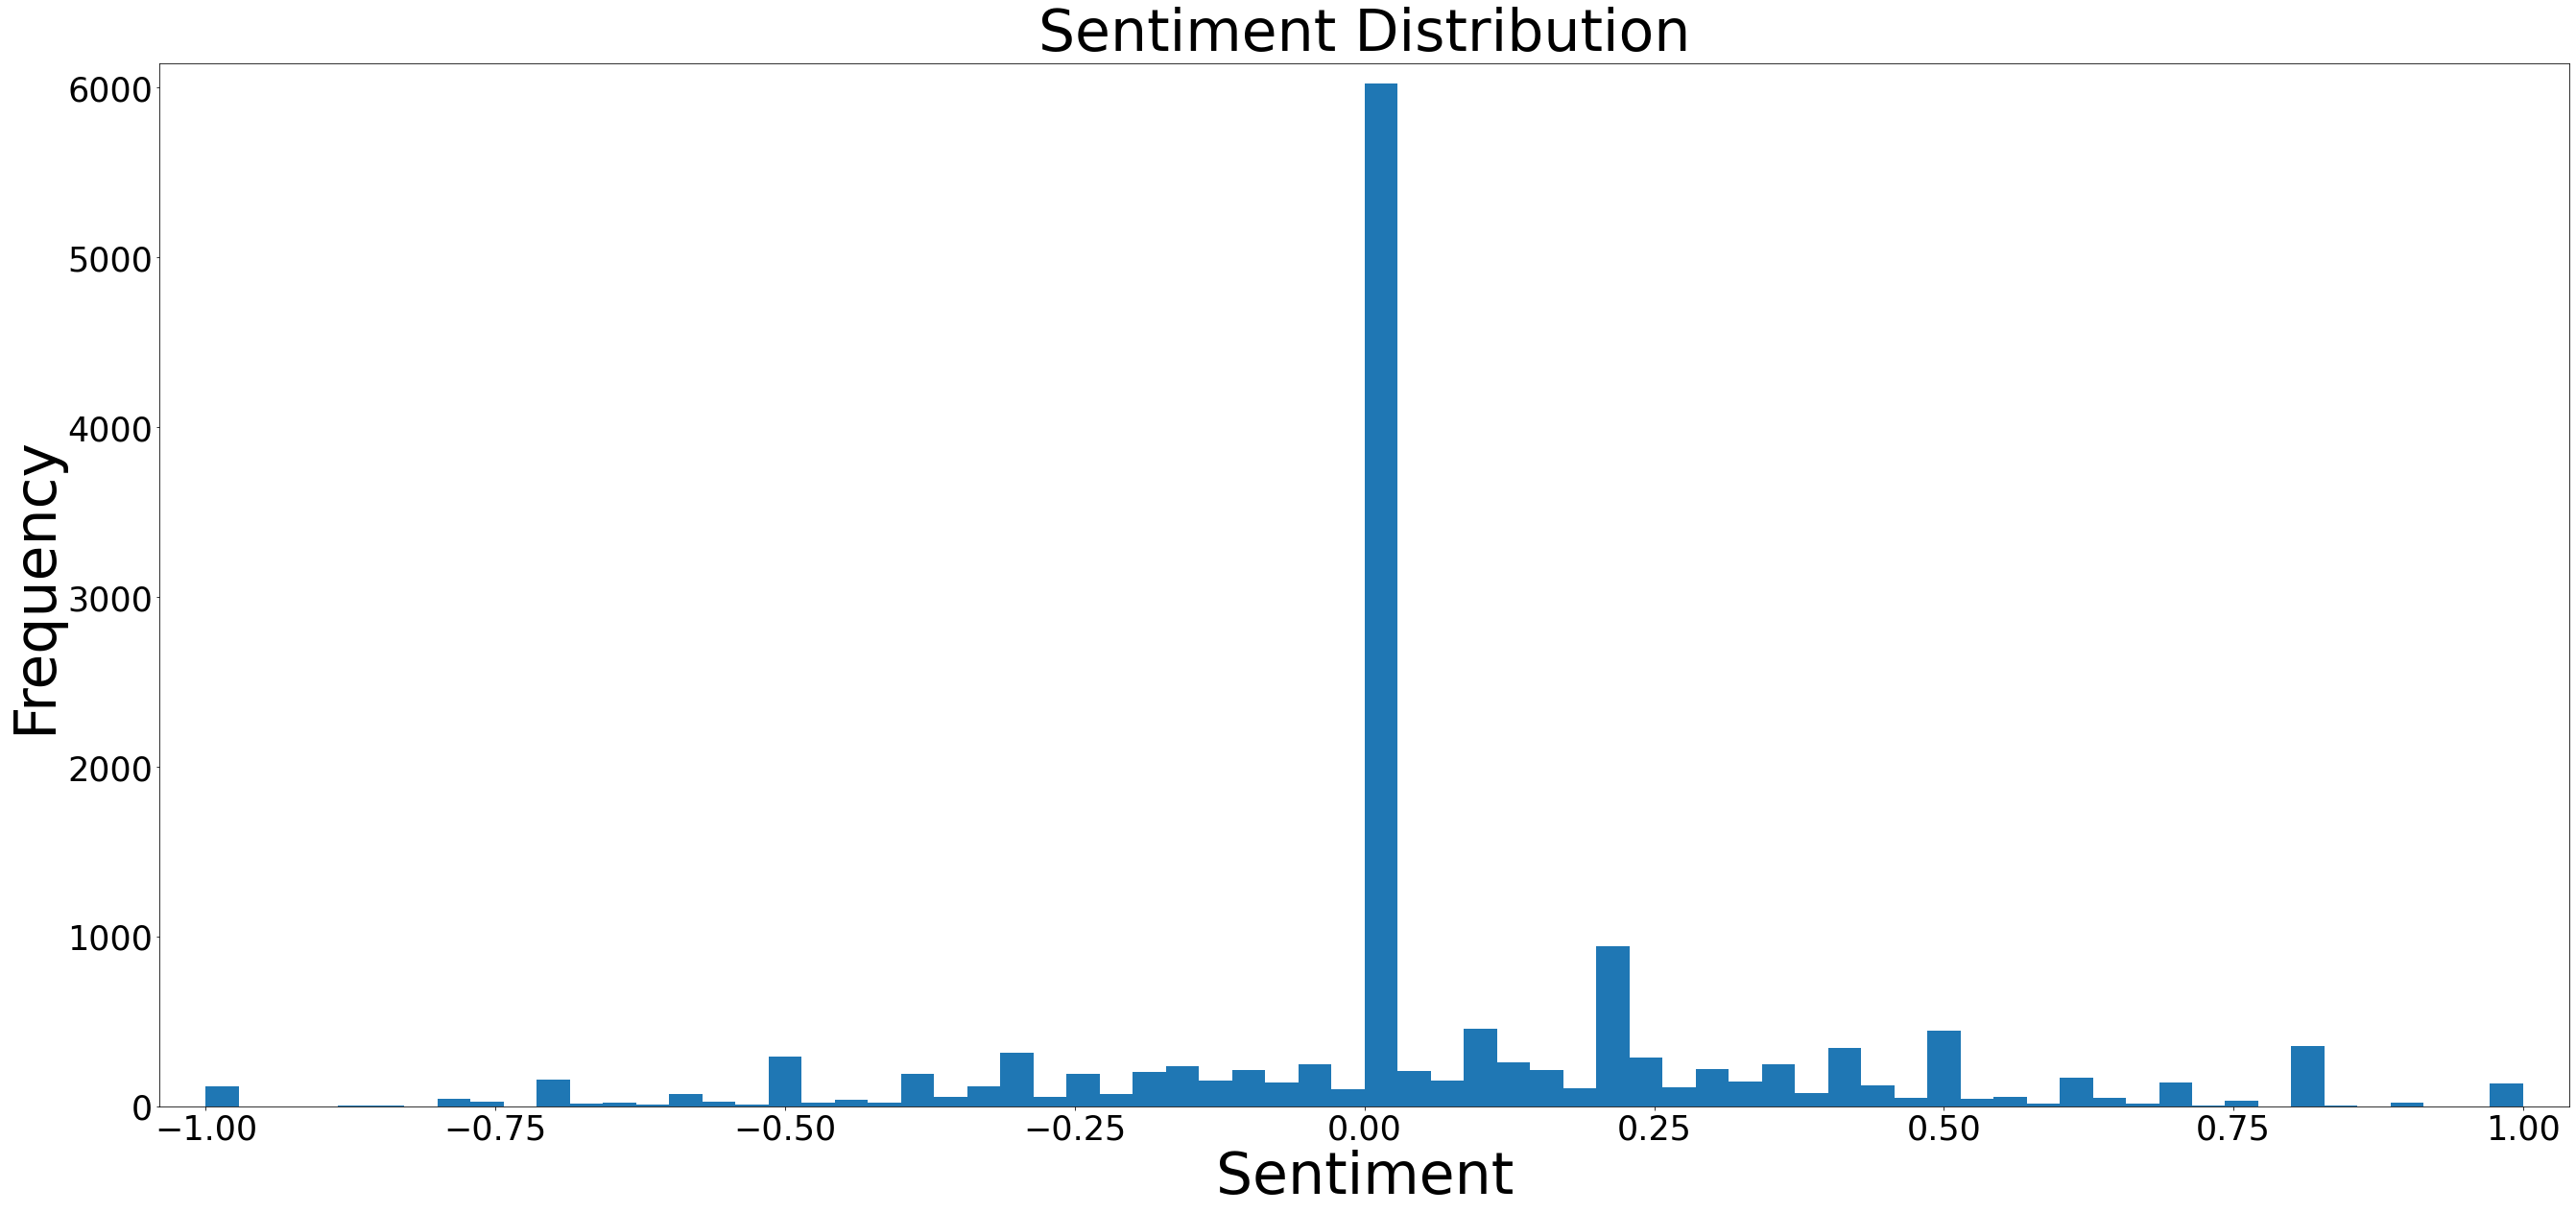

In [82]:
plt.figure(figsize=(45,20))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=60)
plt.xticks(fontsize=35)
plt.ylabel('Frequency', fontsize=60)
plt.yticks(fontsize=35)
plt.hist(df_cleaned['Sentiment'], bins=70)
plt.title('Sentiment Distribution', fontsize=60)
plt.show()

C:\Users\princ\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(array([0, 1, 2]),
 [Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')])

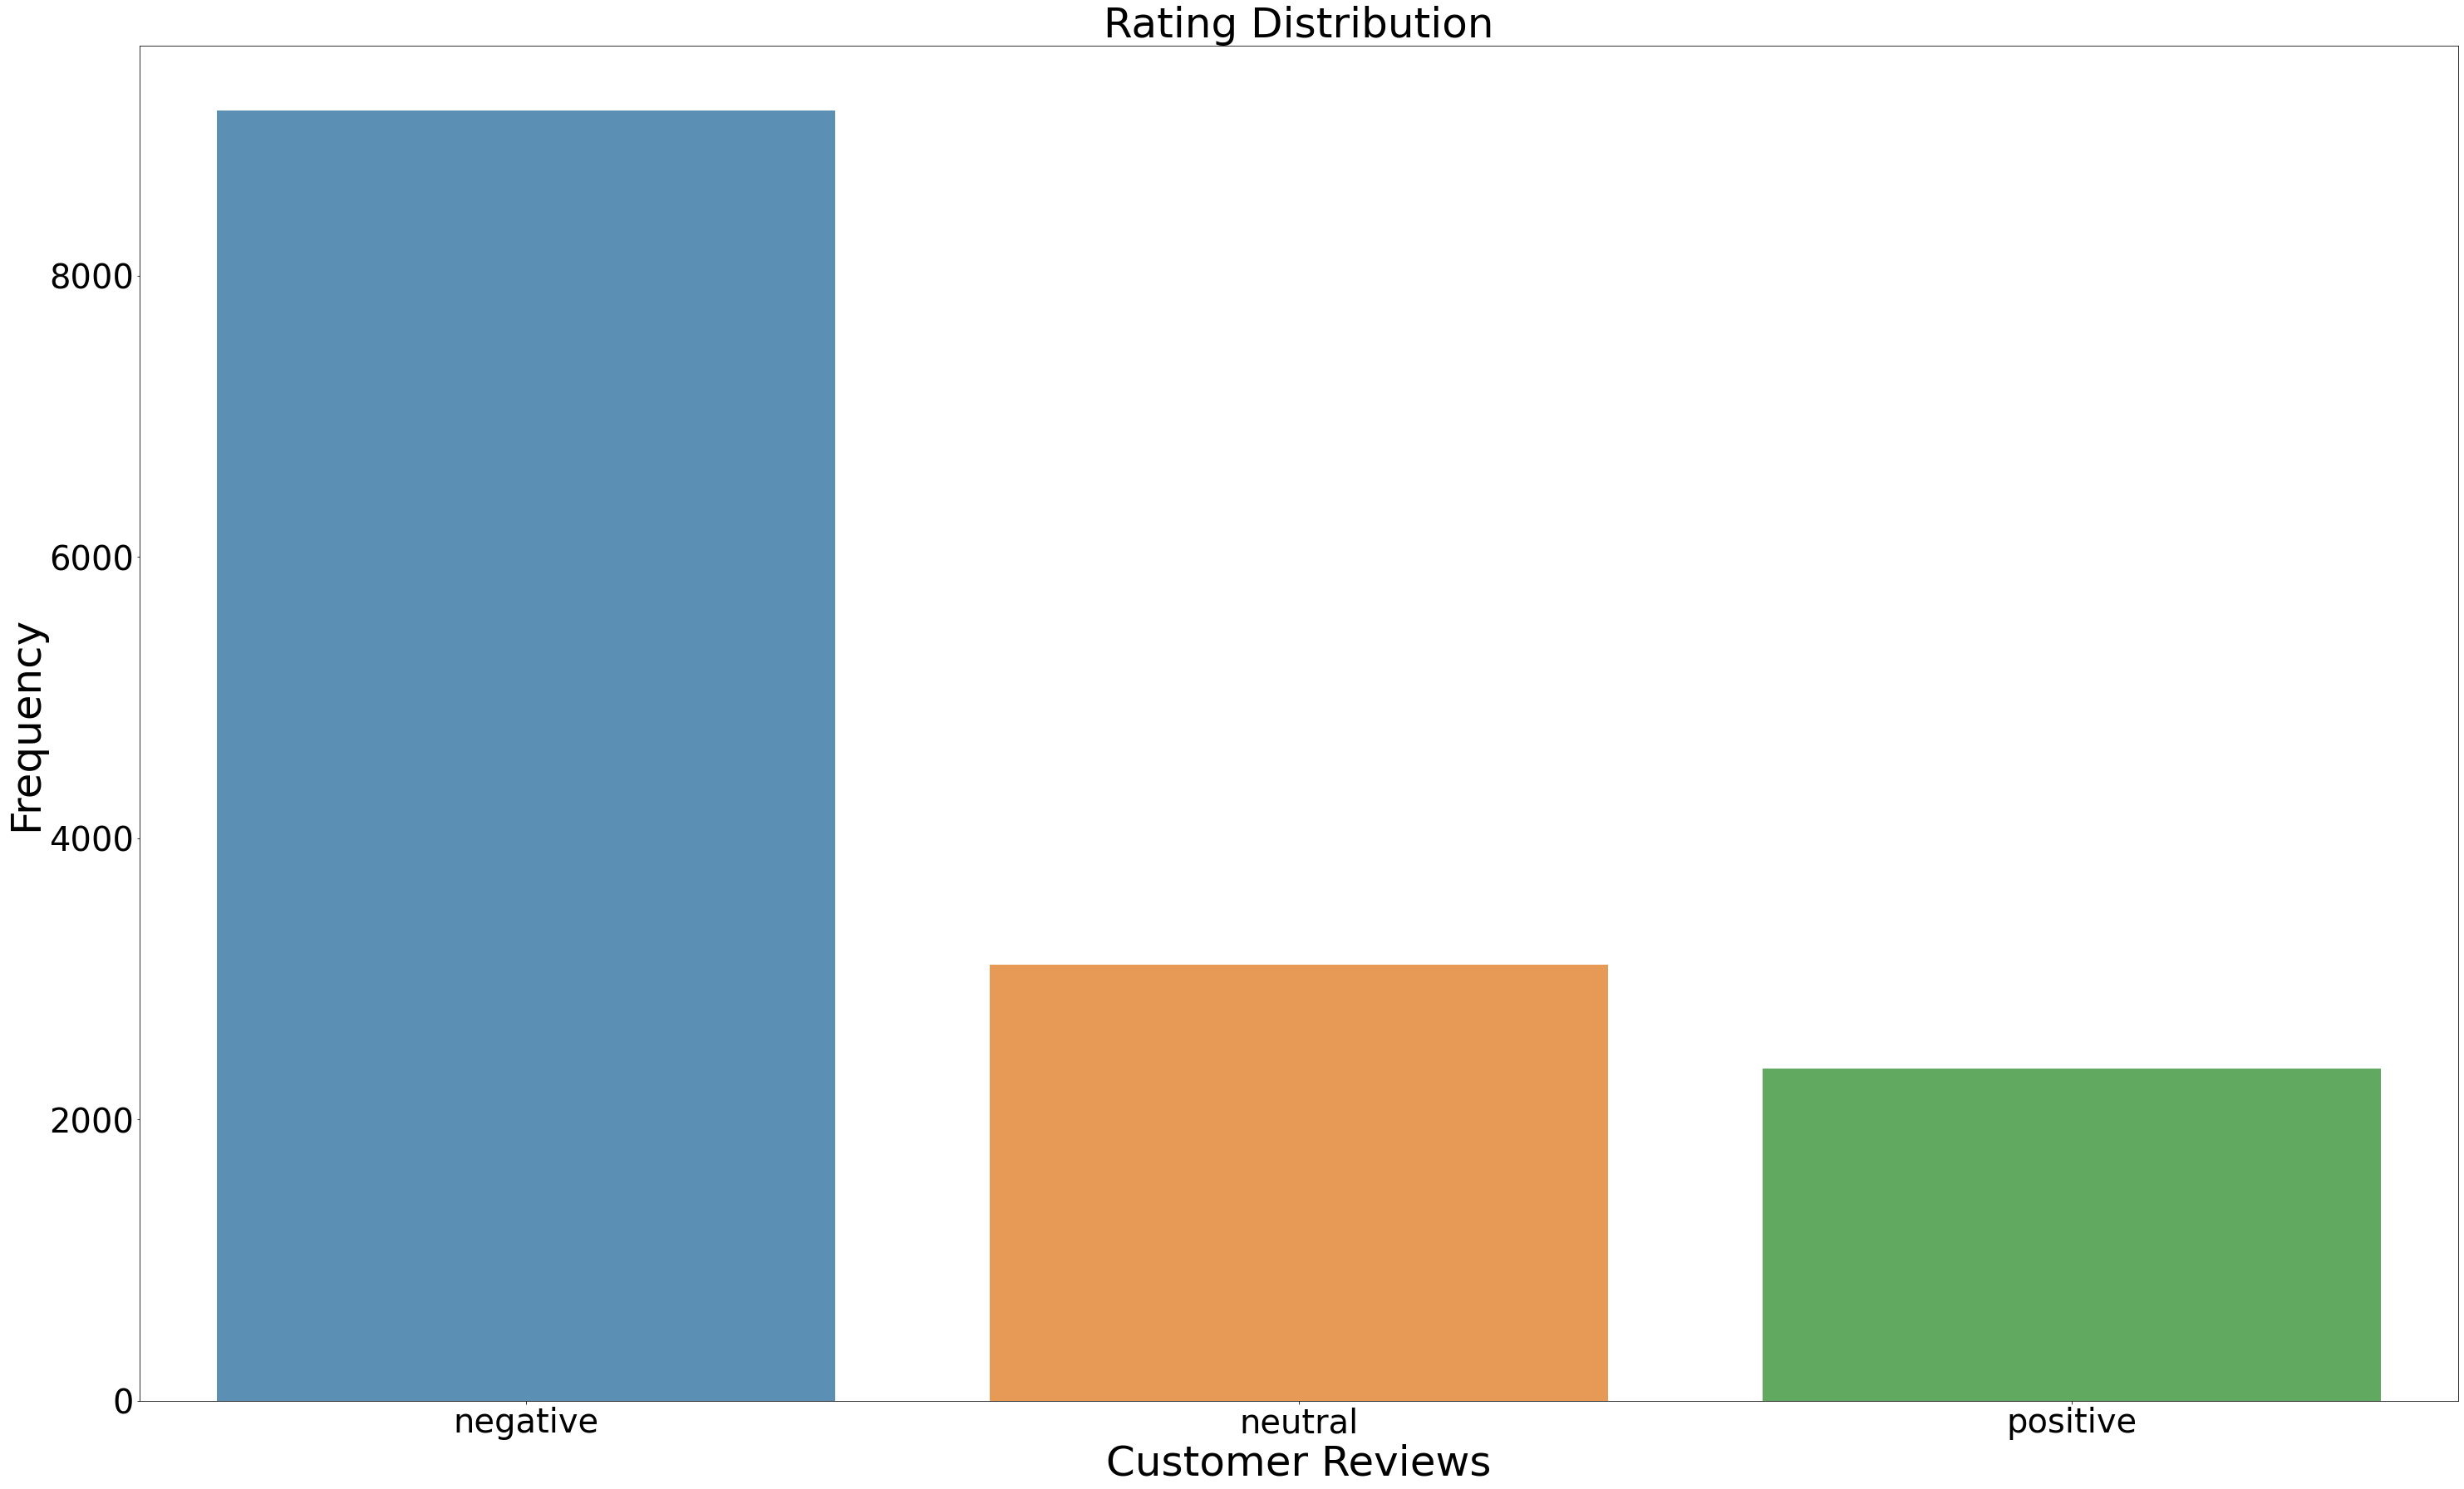

In [83]:
x_rating = df_cleaned.sentiment_polarity.value_counts()
y_rating = x_rating.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(x_rating.index, x_rating.values, alpha=0.8)
plt.title("Rating Distribution", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Customer Reviews', fontsize=50)
plt.xticks(fontsize=40)

<AxesSubplot:title={'center':'Percentage of Reviews'}, ylabel='sentiment_polarity'>

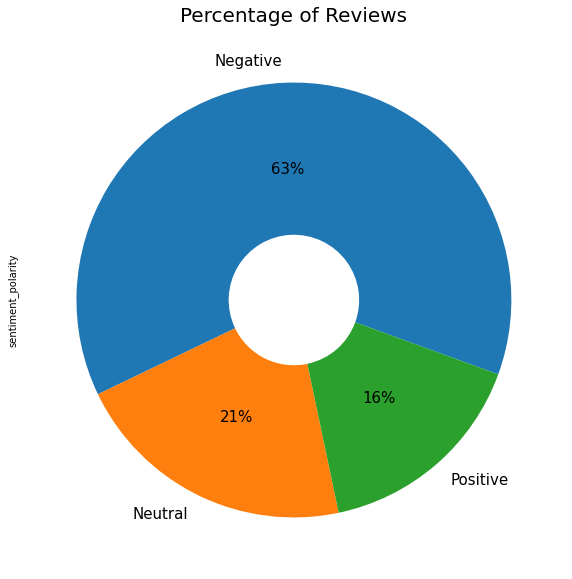

In [84]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Reviews', fontsize=20)
df_cleaned.sentiment_polarity.value_counts().plot(kind='pie', labels=['Negative', 'Neutral', 'Positive'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})

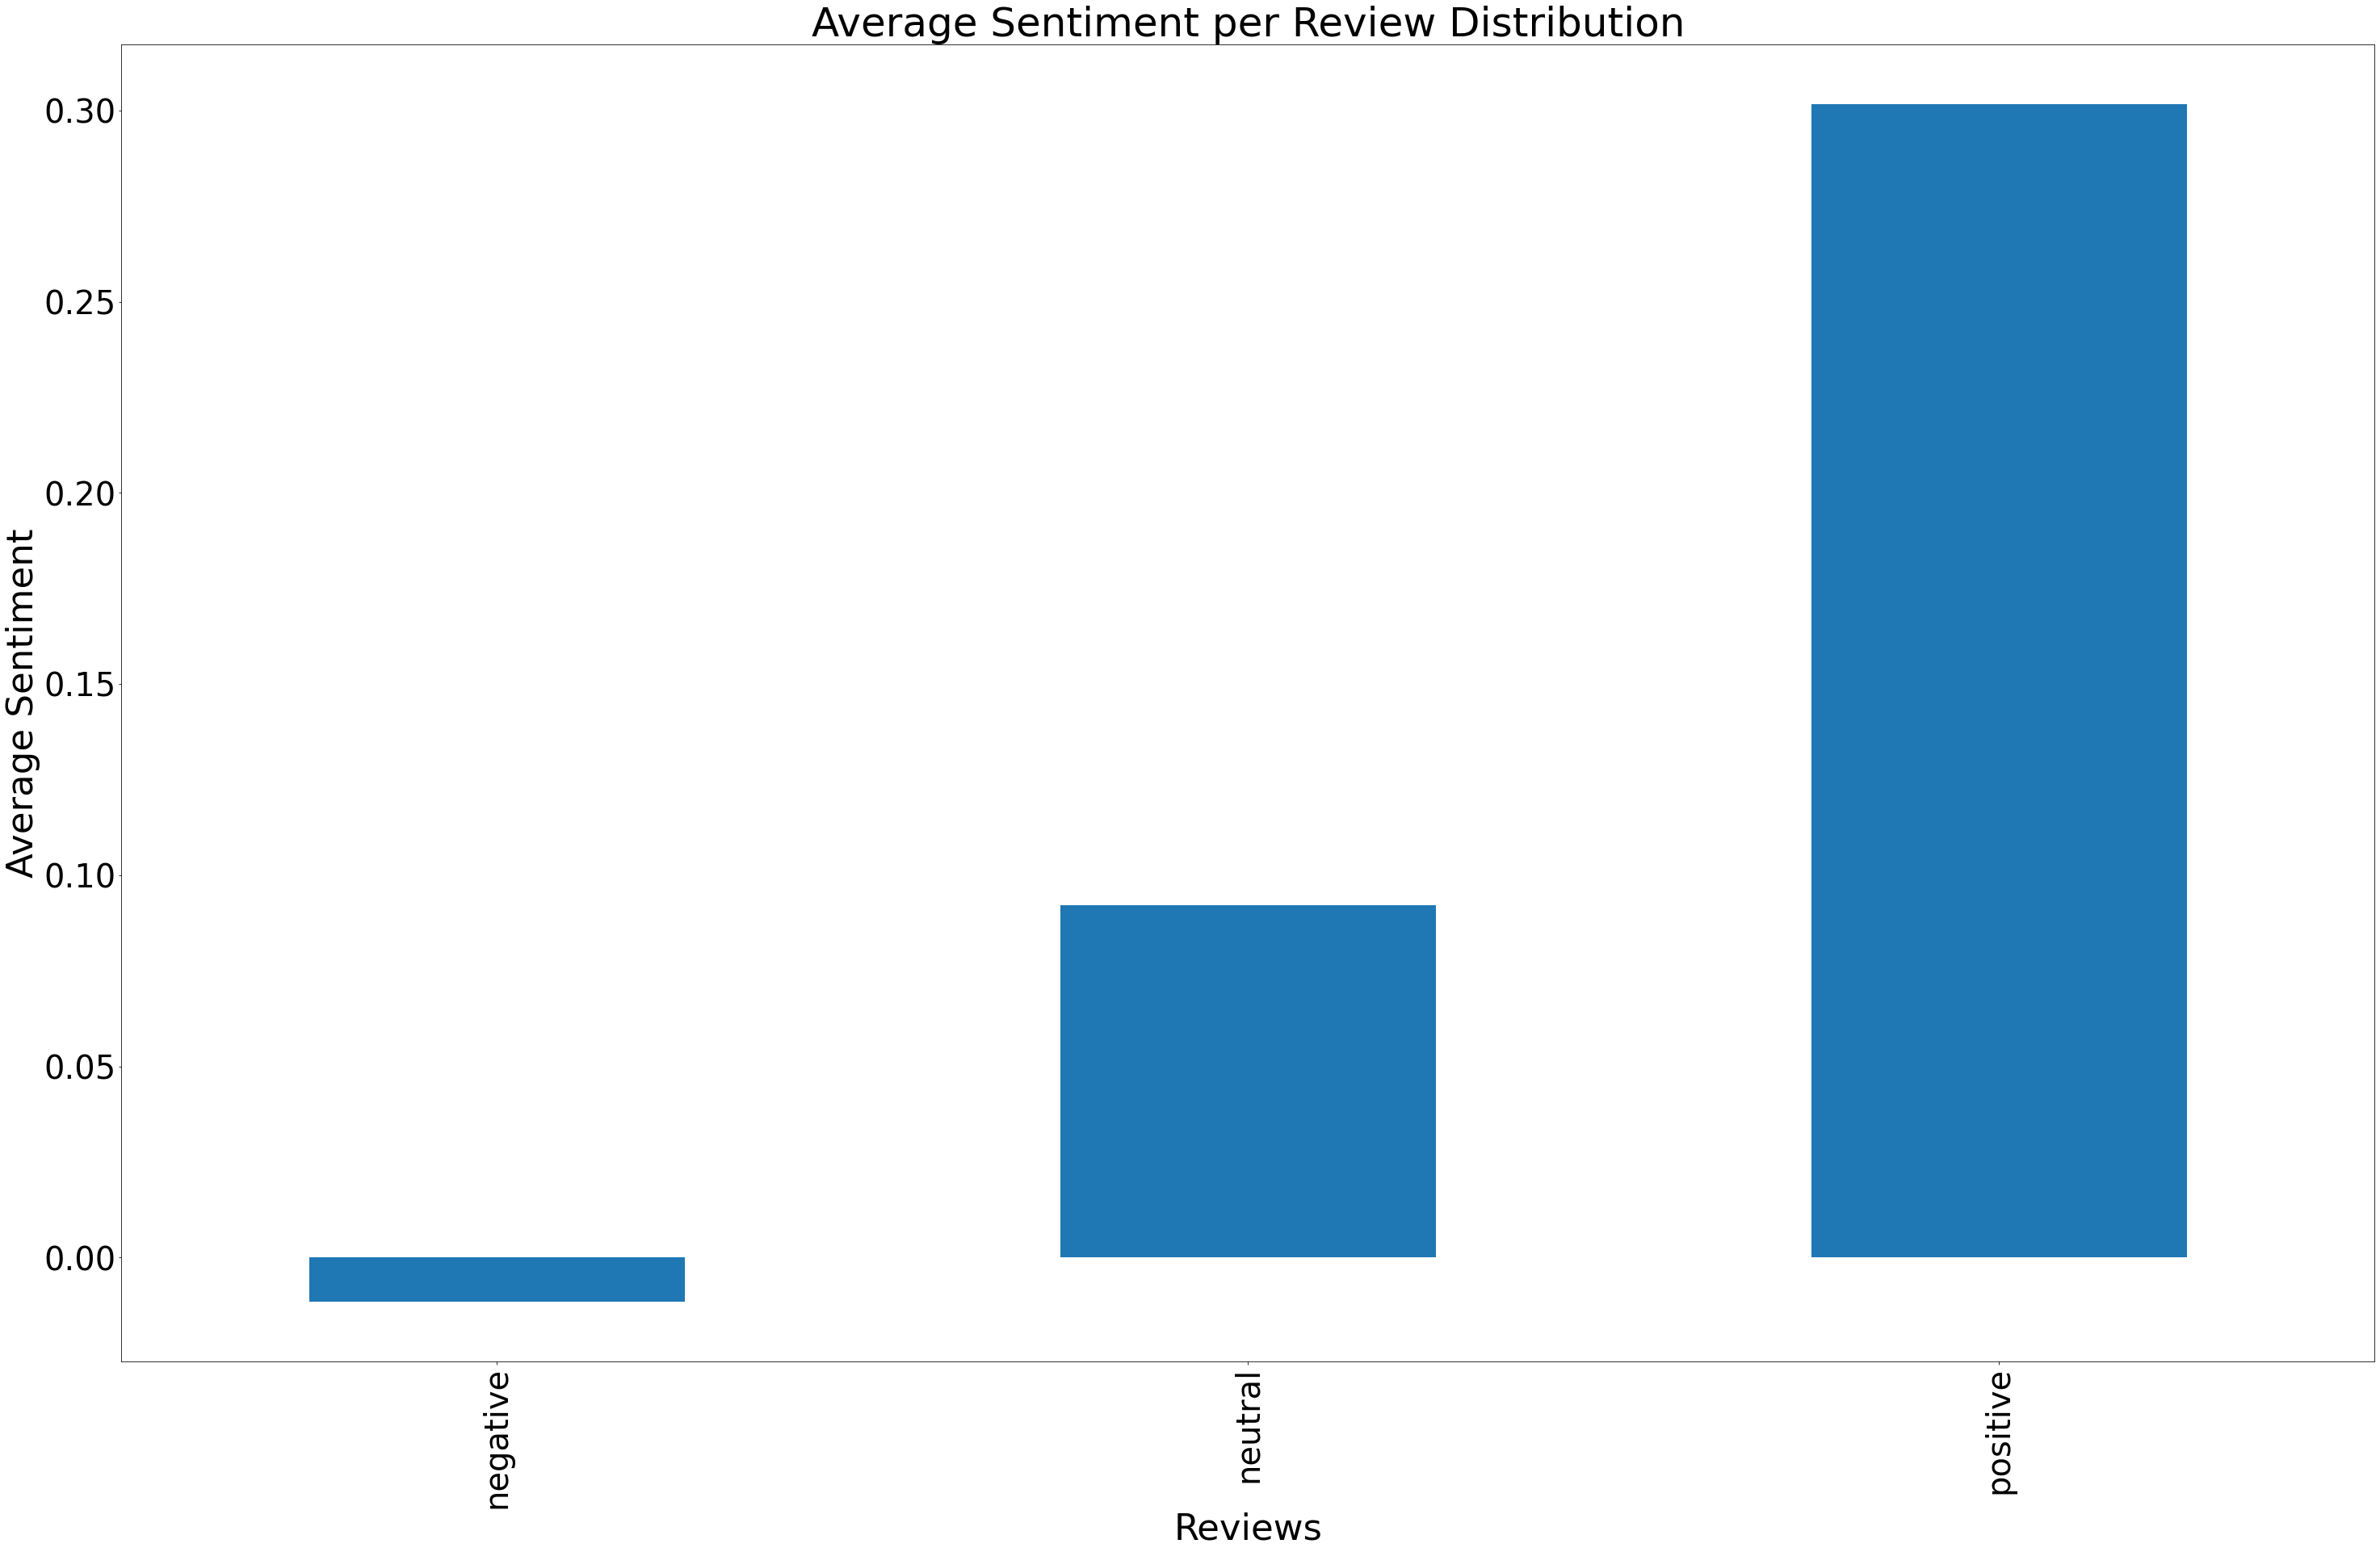

In [85]:
polarity_avg = df_cleaned.groupby('sentiment_polarity')['Sentiment'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Reviews', fontsize=45)
plt.ylabel('Average Sentiment', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Sentiment per Review Distribution', fontsize=50)
plt.show()